In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [2]:
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

In [3]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [4]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim)
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]
                
                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [5]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

In [6]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

In [7]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

In [8]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

In [9]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

In [10]:
def to_np(x):
    return x.detach().cpu().numpy()

In [11]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None:
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [12]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p])
            clear_output(wait=True)

In [13]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

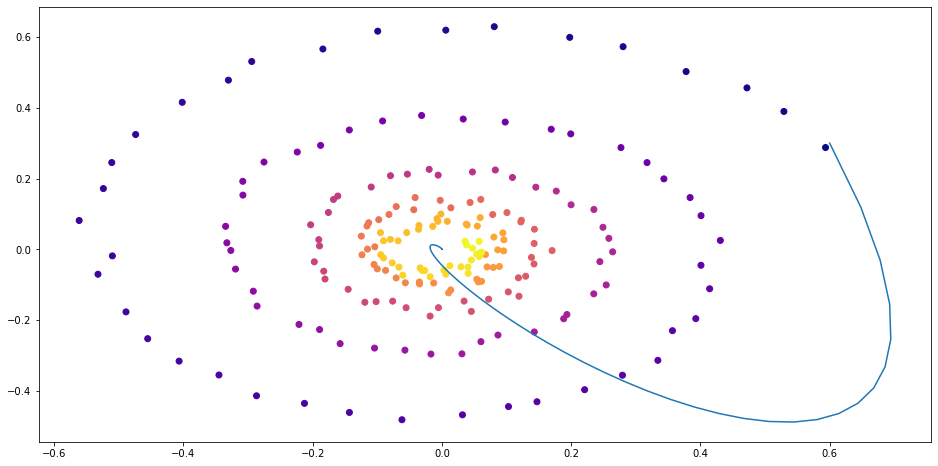

In [14]:
conduct_experiment(ode_true, ode_trained, 1000, "comp", plot_freq=30)

In [16]:
def ce_loss(ode_true, ode_trained, n_steps, name, plot_freq=10, K=200):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    losses = []

    t_max = 6.29*5
    n_points = K

    index_np = np.arange(0, n_points, 1, dtype=int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())
        losses.append(loss.detach().numpy())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

    return np.squeeze(losses)
    

In [16]:
import time
K_t = np.arange(65, 200, 10)
t_arr = []
for K in K_t:
    start_time = time.time()
    ode_trained = NeuralODE(RandomLinearODEF())
    ode_true = NeuralODE(SpiralFunctionExample())
    ce_loss(ode_true, ode_trained, 1000, "comp", plot_freq=1000, K=K)
    end_time = time.time()
    print(start_time - end_time)
    t_arr.append(end_time - start_time)

-29.865408897399902


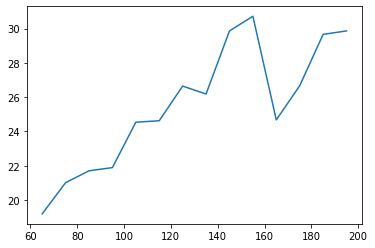

In [17]:
plt.plot(K_t, t_arr)

In [ ]:
ode_true = NeuralODE(SpiralFunctionExample())

n_runs = 10
K_arr = [65, 100, 200]
k_losses = []

# loop through all K values
for K in K_arr:
    av_losses = []
    # run multiple times for one K value
    for n in range(n_runs):
        print(f"Progress: K={K}, n={n}", end="\r")
        ode_trained = NeuralODE(RandomLinearODEF())
        loss = ce_loss(ode_true, ode_trained, 4000, "comp", plot_freq=1000, K=K)
        loss_val = np.mean(loss[-100:-1])
        av_losses.append(loss)
    k_losses.append(av_losses)


In [42]:
ode_true = NeuralODE(SpiralFunctionExample())

n_runs = 10
loss_thresh = 1#5e-4
K_arr = [65, 100, 200]
k_losses = []
K_count = []

# loop through all K values
for K in K_arr:
    av_losses = []
    count = 0
    # run multiple times for one K value
    for n in range(n_runs):
        print(f"Progress: K={K}, n={n}", end="\r")
        loss_val = loss_thresh
        # run as long as the loss function has sufficiently decreased in the end
        while loss_val >= loss_thresh:
            count += 1
            ode_trained = NeuralODE(RandomLinearODEF())
            loss = ce_loss(ode_true, ode_trained, 4000, "comp", plot_freq=1000, K=K)
            loss_val = np.mean(loss[-100:-1])
        av_losses.append(loss)
    K_count.append(count - n_runs)
    k_losses.append(av_losses)

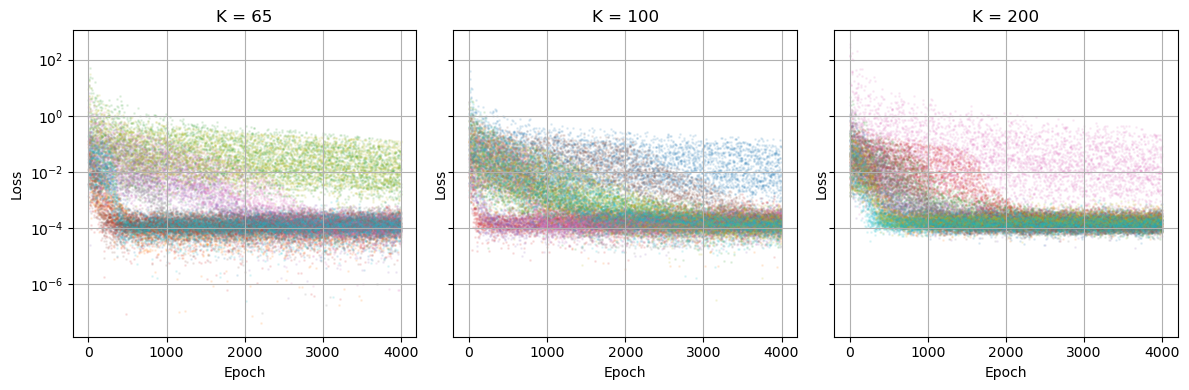

In [58]:
colors = ["tab:blue", "tab:green", "tab:orange"]


fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=100, sharey=True)
for idx, loss_batch in enumerate(k_losses):
    ax = axs[idx]
    for single_loss in loss_batch:
        ax.plot(single_loss, "o", alpha=.1, markersize=1, zorder=1)
    ax.set_yscale("log")
    ax.grid(True)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.set_title(f"K = {K_arr[idx]}")
    plt.tight_layout()

Text(0.5, 0, 'Epoch')

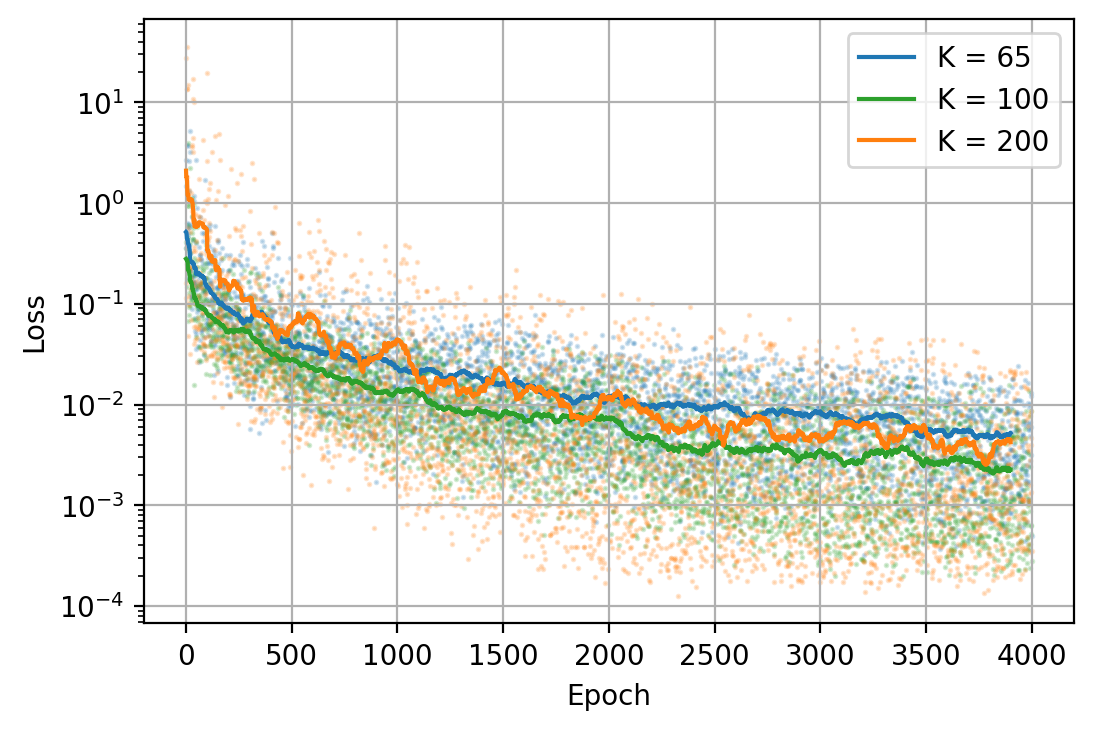

In [52]:
plt.figure(dpi=200)

for idx, losses in enumerate(k_losses):
    av_loss = np.mean(losses, axis=0)
    running_mean = np.convolve(av_loss, np.ones(100) / 100, mode='valid')
    
    plt.plot(av_loss, "o", alpha=.2, markersize=1, color=colors[idx], zorder=1)
    plt.plot(running_mean, color=colors[idx], zorder=2, label=f"K = {K_arr[idx]}")
    
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [65]:
count

9

Text(0.5, 0, 'Epoch')

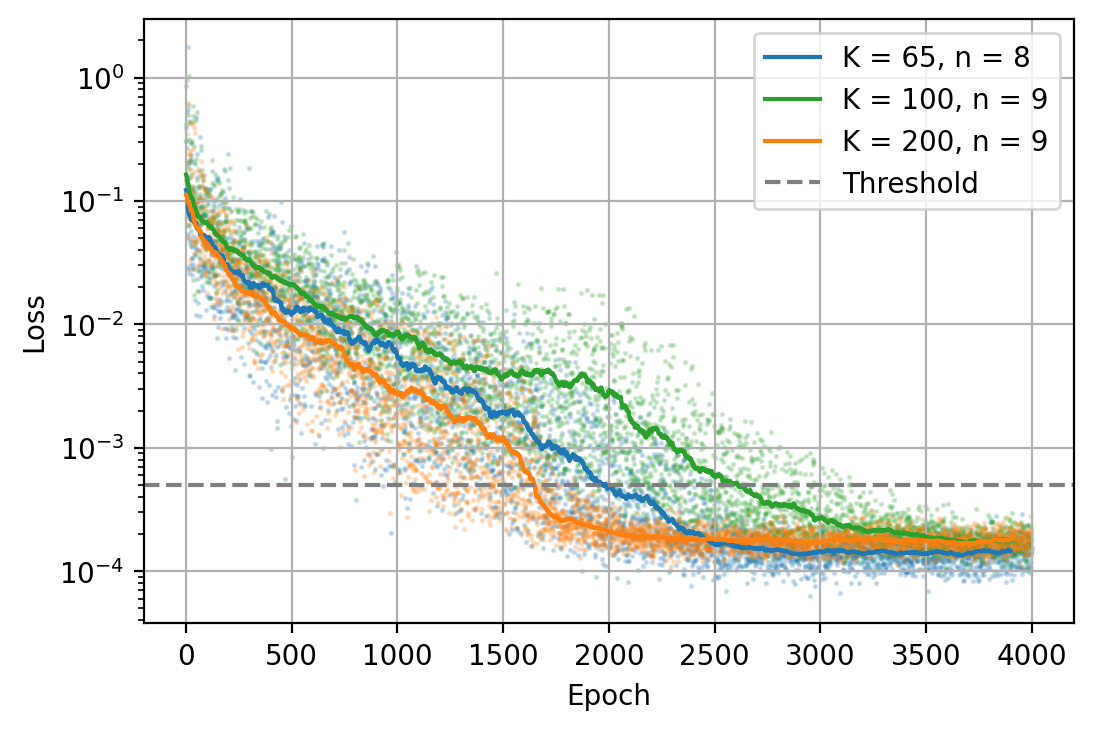

In [67]:
loss_thresh = 5e-4

plt.figure(dpi=200)

for idx, losses in enumerate(k_losses):
    av_bool = []
    count = 0
    for single_loss in losses:
        if np.mean(single_loss[-100:-1]) < loss_thresh:
            av_bool.append(True)
            count += 1
        else:
            av_bool.append(False)
    
    av_loss = np.mean(np.array(losses)[av_bool], axis=0)
    running_mean = np.convolve(av_loss, np.ones(100) / 100, mode='valid')
    
    plt.plot(av_loss, "o", alpha=.2, markersize=1, color=colors[idx], zorder=1)
    plt.plot(running_mean, color=colors[idx], zorder=2, label=f"K = {K_arr[idx]}, n = {count}")

plt.axhline(loss_thresh, label="Threshold", ls="dashed", color="tab:gray")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.ylabel("Loss")
plt.xlabel("Epoch")

6
3
5


Text(0.5, 0, 'Epoch')

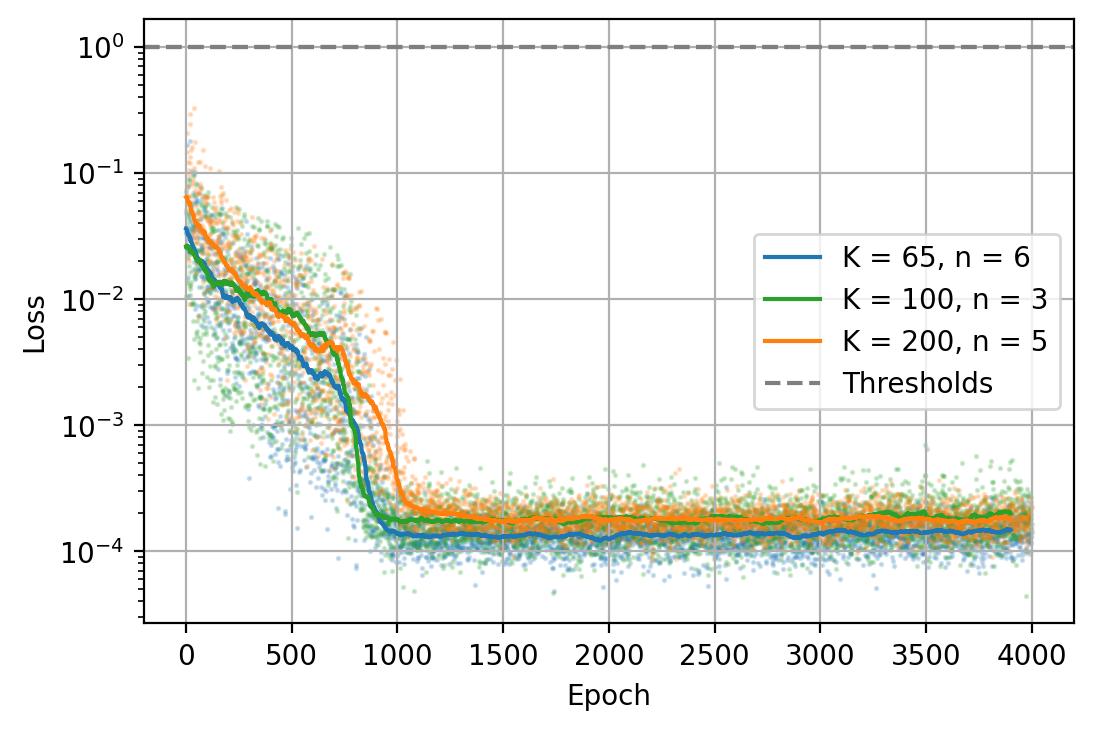

In [74]:
loss_thresh = 1
high_thresh = 1

plt.figure(dpi=200)

for idx, losses in enumerate(k_losses):
    av_bool = []
    count = 0
    for single_loss in losses:
        if (np.mean(single_loss[-100:-1]) < loss_thresh) and (np.max(single_loss[0:10]) < high_thresh):
            av_bool.append(True)
            count += 1
        else:
            av_bool.append(False)
    print(count)
    av_loss = np.mean(np.array(losses)[av_bool], axis=0)
    running_mean = np.convolve(av_loss, np.ones(100) / 100, mode='valid')
    
    plt.plot(av_loss, "o", alpha=.2, markersize=1, color=colors[idx], zorder=1)
    plt.plot(running_mean, color=colors[idx], zorder=2, label=f"K = {K_arr[idx]}, n = {count}")

plt.axhline(loss_thresh, label="Thresholds", ls="dashed", color="tab:gray")
plt.axhline(high_thresh, ls="dashed", color="tab:gray")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.ylabel("Loss")
plt.xlabel("Epoch")

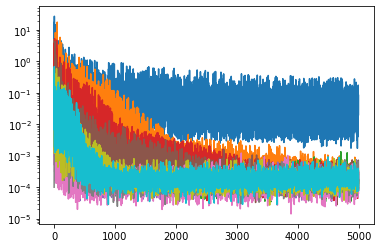

In [41]:
for _loss in av_losses:
    plt.plot(_loss)
    plt.yscale("log")

Text(0.5, 0, 'Epoch')

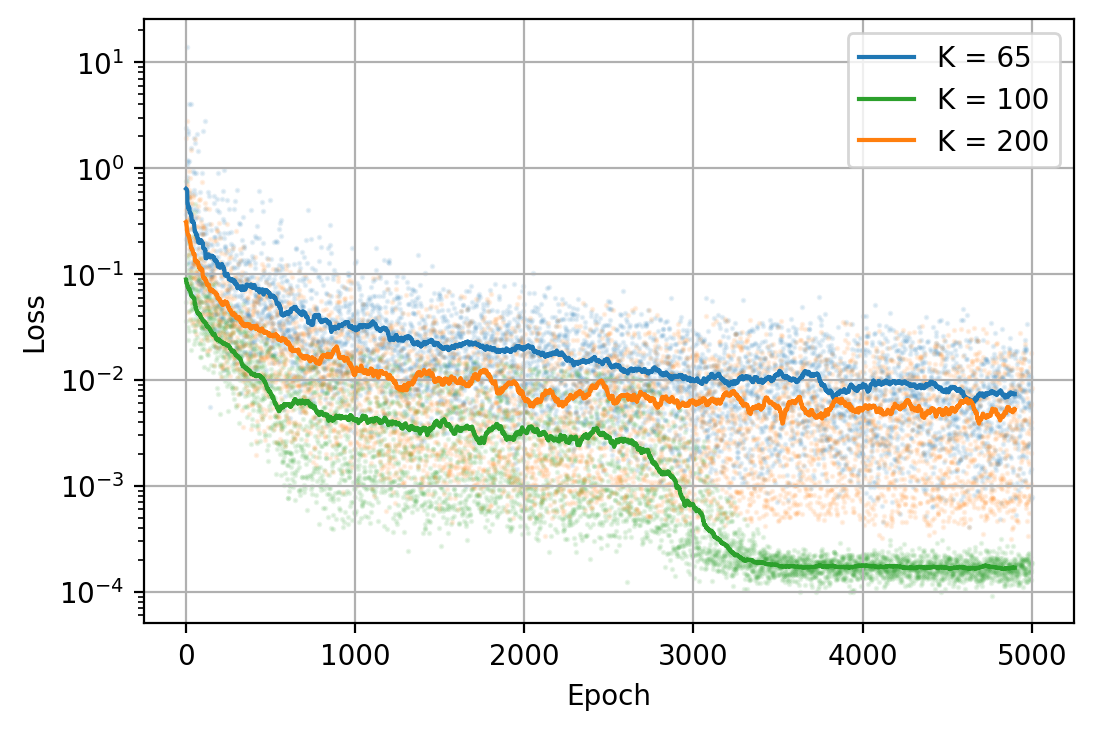

In [37]:
plt.figure(dpi=200)
colors = ["tab:blue", "tab:green", "tab:orange"]
for idx, losses in enumerate(k_losses):
    # Calculate the running mean using a window size of 10
    running_mean = np.convolve(losses, np.ones(100) / 100, mode='valid')
    
    plt.plot(losses, "o", alpha=.1, markersize=1, color=colors[idx], zorder=1)
    plt.plot(running_mean, color=colors[idx], zorder=2, label=f"K = {K_arr[idx]}")

plt.yscale("log")
plt.legend()
plt.grid(True)
plt.ylabel("Loss")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

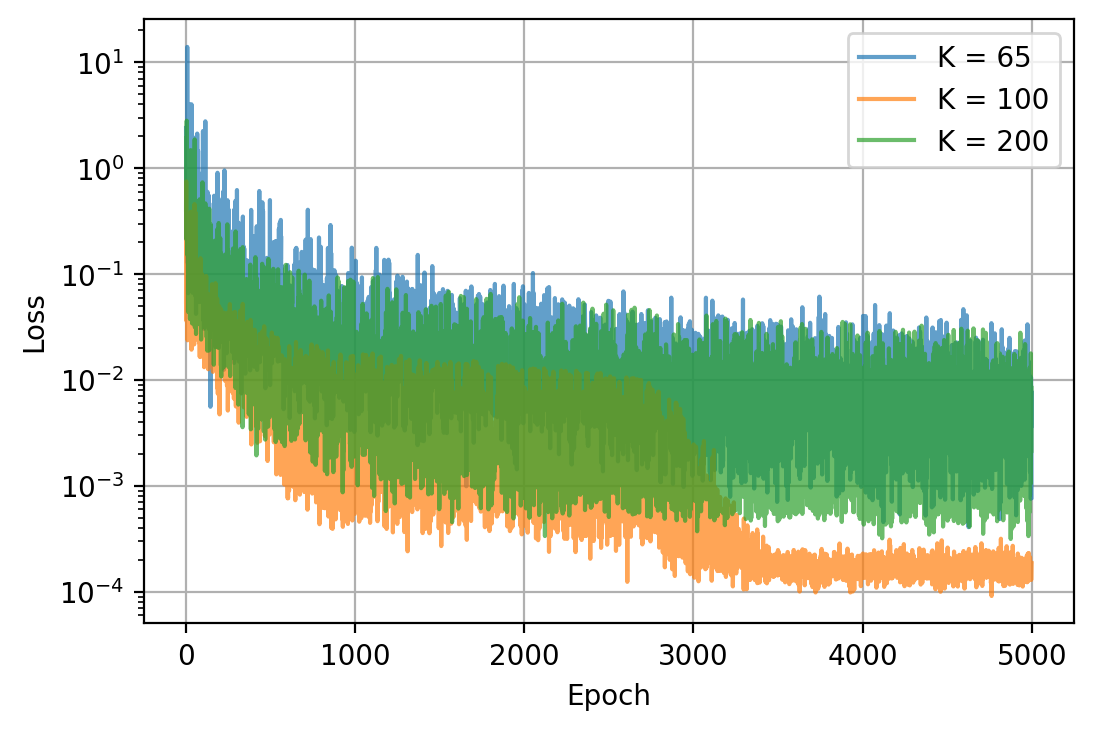

In [19]:
plt.figure(dpi=200)
for idx, losses in enumerate(k_losses):
    plt.plot(losses, label=f"K = {K_arr[idx]}", alpha=.7)
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [35]:
K_count

[6, 8, 11]

In [37]:
K_count

[0, 0, 0]

Text(0.5, 0, 'Epoch')

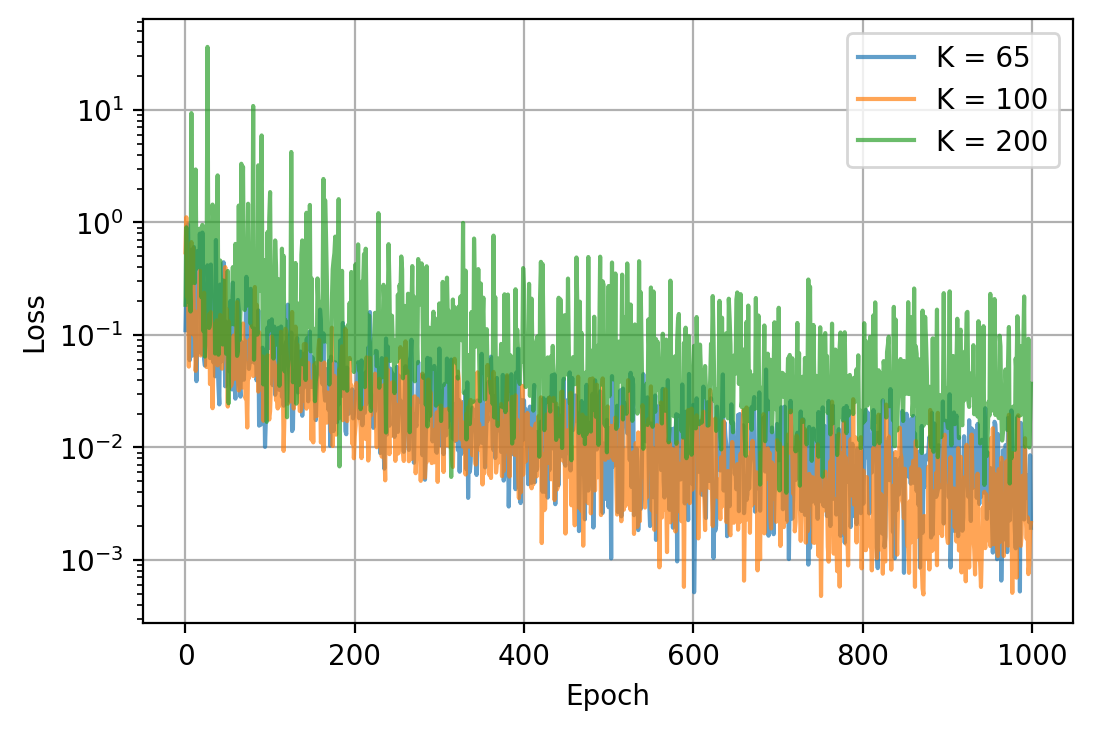

In [38]:
plt.figure(dpi=200)
for idx, losses in enumerate(k_losses):
    plt.plot(losses, label=f"K = {K_arr[idx]}", alpha=.7)
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.ylabel("Loss")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

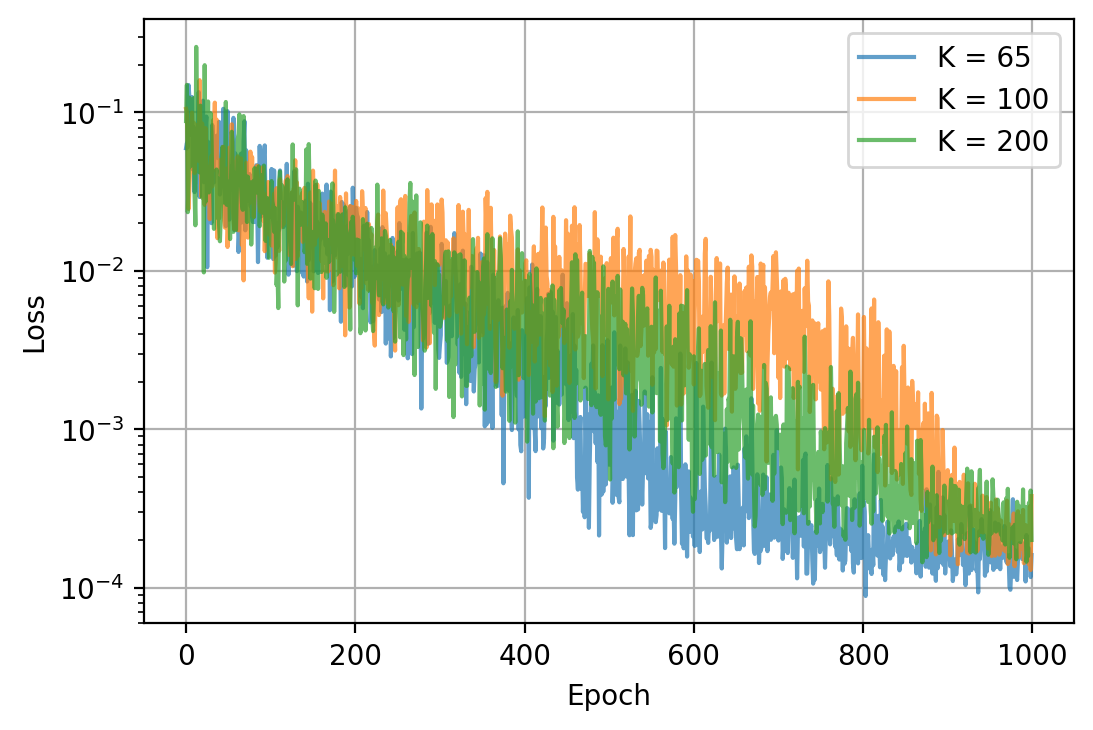

In [19]:
plt.figure(dpi=200)
for idx, losses in enumerate(k_losses):
    plt.plot(losses, label=f"K = {K_arr[idx]}", alpha=.7)
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.ylabel("Loss")
plt.xlabel("Epoch")

The parameter K represents the number of points used to discretize the time interval.Increasing the value of K will result in a higher density of time points within the time interval, potentially providing more fine-grained observations and batches during training. However, it will also increase the computational cost as more points need to be evaluated and processed.

In [20]:
# Define the FNN architecture: taken from previous project
class FNN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden, n_neurons_h, A):
        super(FNN, self).__init__()
        self.hidden_layers = nn.ModuleList() # empty nn.ModuleList to store hidden layers
        self.hidden_layers.append(nn.Linear(input_size, n_neurons_h)) # create first hidden layer
        for i in range(n_hidden-1):
            self.hidden_layers.append(nn.Linear(n_neurons_h, n_neurons_h)) # create the rest of the hidden layers
        self.output_layer = nn.Linear(n_neurons_h, output_size) # create output layer
        self.activation = A

    def forward(self, x):
        '''
        input tensor x is used to perform forward pass through the FNN to create output tensor
        '''
        for layer in self.hidden_layers:
            x = self.activation(layer(x)) # go through all hidden layers and create input for next hiddenlayer
        x = self.output_layer(x) # produce output tensor # uses softmax for 2 outputs, sigmoid for 1 output
        return x

# define ODEF with NN
class NNODEF(ODEF):
    def __init__(self):
        super(NNODEF, self).__init__()
        self.hidden_size = 16
        
        # Define the FNN architecture
        self.fnn = FNN(2, 2, 1, self.hidden_size, nn.ELU())

    def forward(self, z, t):
        # Implement the forward pass of the FNN
        out = self.fnn(z)
        return out

In [21]:
def ce_loss_stop(ode_true, ode_trained, n_steps, name, plot_freq=10, K=200, max_loss=1e-4, counter_thres=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    losses = []

    t_max = 6.29*5
    n_points = K

    index_np = np.arange(0, n_points, 1, dtype=int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    loss = 1
    # counter = 0
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())
        losses.append(loss.detach().numpy())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        print(f"{loss}", end="\r")
        if loss < max_loss:
          counter += 1
          if counter == counter_thres:
              break
        else:
          counter = 0
        
    z_p = ode_trained(z0, times, return_whole_sequence=True)

    plot_trajectories(obs=[obs], times=[times], trajs=[z_p])
    clear_output(wait=True)
    return np.squeeze(losses)
    

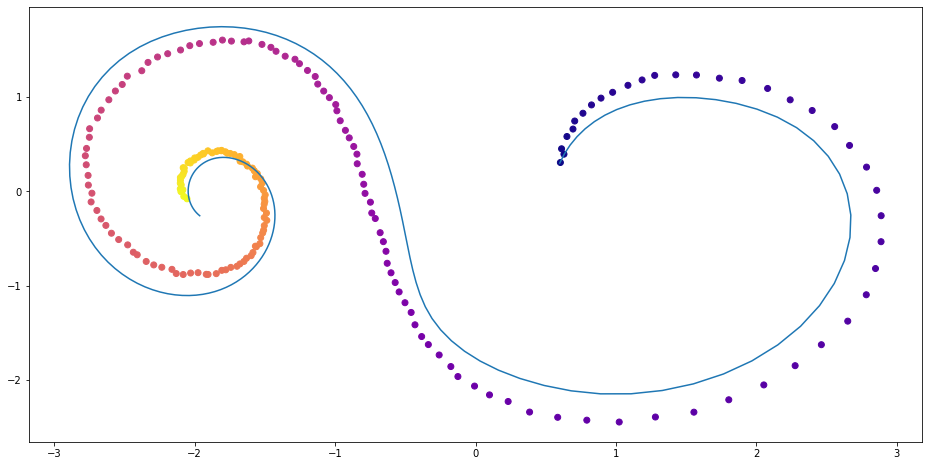

In [27]:
min_count = 3
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true_com = NeuralODE(func)

func_lin = NNODEF()
ode_train_hl = NeuralODE(func_lin)

max_loss = 5e-4
loss = ce_loss_stop(ode_true_com, ode_train_hl, 5000, "comp", plot_freq=100, max_loss=max_loss, counter_thres=min_count)

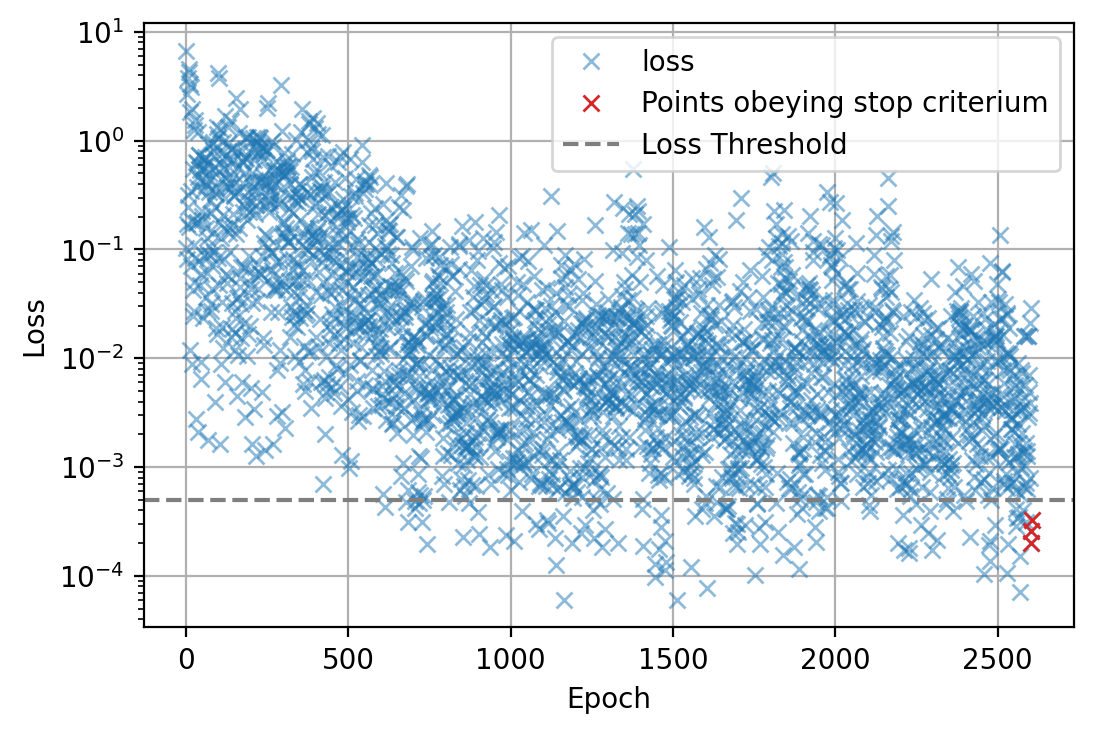

In [31]:
epochs = np.arange(len(loss))
plt.figure(dpi=200)
plt.plot(loss, "x", alpha=0.5, label="loss")
plt.plot(epochs[-min_count:], loss[-min_count:], "x", color="tab:red", label="Points obeying stop criterium")
plt.yscale("log")
plt.axhline(max_loss, color="tab:gray", label="Loss Threshold", ls="dashed")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

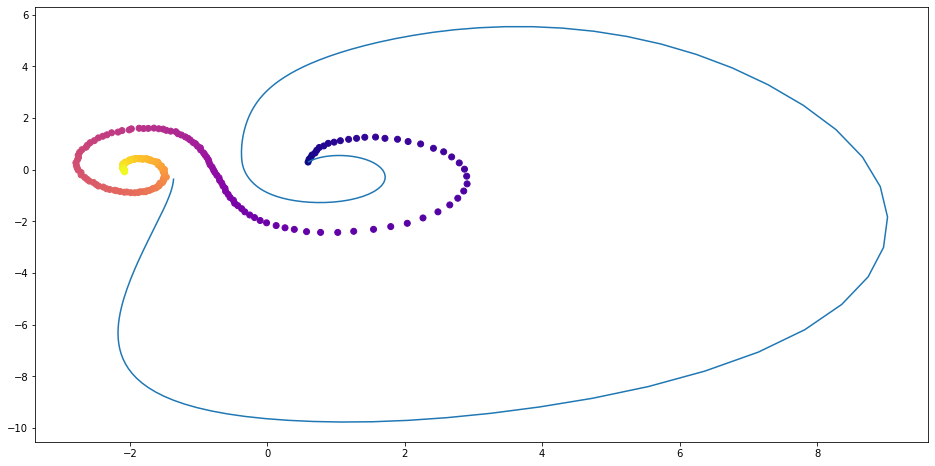

In [24]:
min_count = 3
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true_com = NeuralODE(func)

func_lin = NNODEF()
ode_train_hl = NeuralODE(func_lin)

max_loss = 5e-4
loss = ce_loss_stop(ode_true_com, ode_train_hl, 10000, "comp", plot_freq=100, max_loss=max_loss, counter_thres=min_count)

TypeError: 'bool' object is not iterable

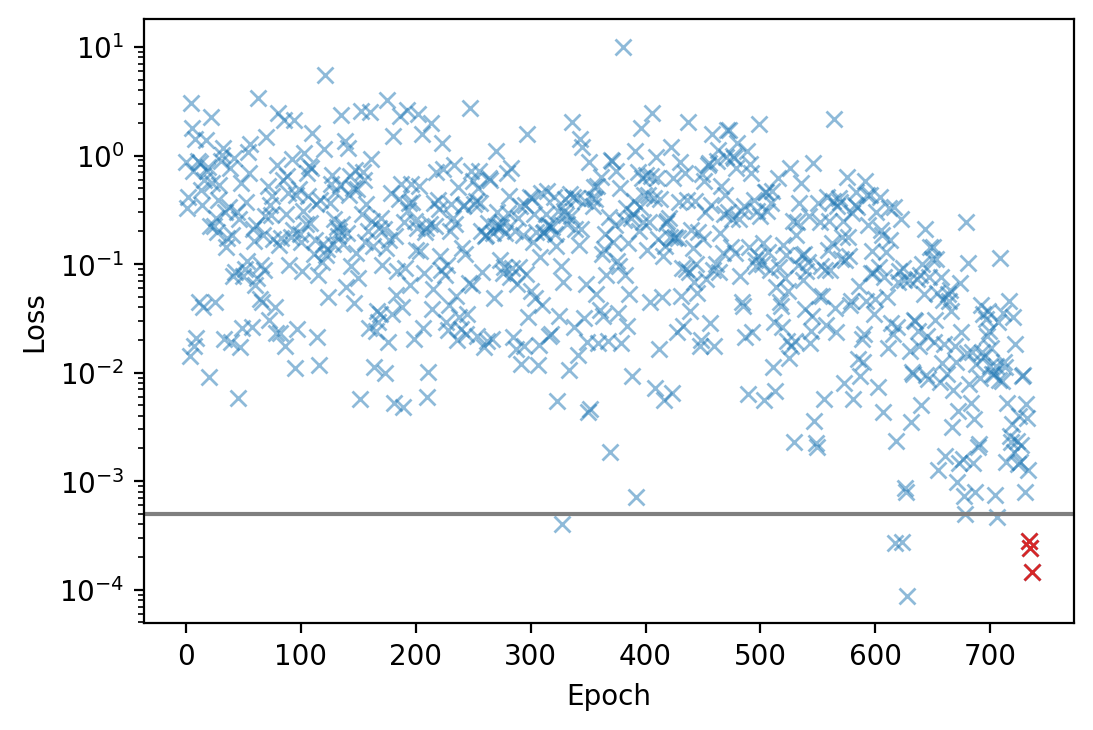

In [26]:
epochs = np.arange(len(loss))
plt.figure(dpi=200)
plt.plot(loss, "x", alpha=0.5)
plt.plot(epochs[-min_count:], loss[-min_count:], "x", color="tab:red", label="Loss")
plt.yscale("log")
plt.axhline(max_loss, color="tab:gray", label="Loss Threshold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(True)
plt.show()